In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
data = pd.read_csv("kel4_dataset.csv")
data.dropna(inplace=True)  
data['Frontal Axis (G)'] = data['Frontal Axis (G)'].astype(float)
data['Vertical Axis (G)'] = data['Vertical Axis (G)'].astype(float)
data['Lateral Axis (G)'] = data['Lateral Axis (G)'].astype(float)
data['Antenna ID'] = data['Antenna ID'].astype(int)
data['Activity Label'] = data['Activity Label'] - 1
data['Time (s)'] = pd.to_numeric(data['Time (s)'], errors='coerce') 

X = data[['Time (s)', 'Frontal Axis (G)', 'Vertical Axis (G)', 'Lateral Axis (G)', 'Antenna ID', 'RSSI', 'Phase', 'Frequency']]
y = data['Activity Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

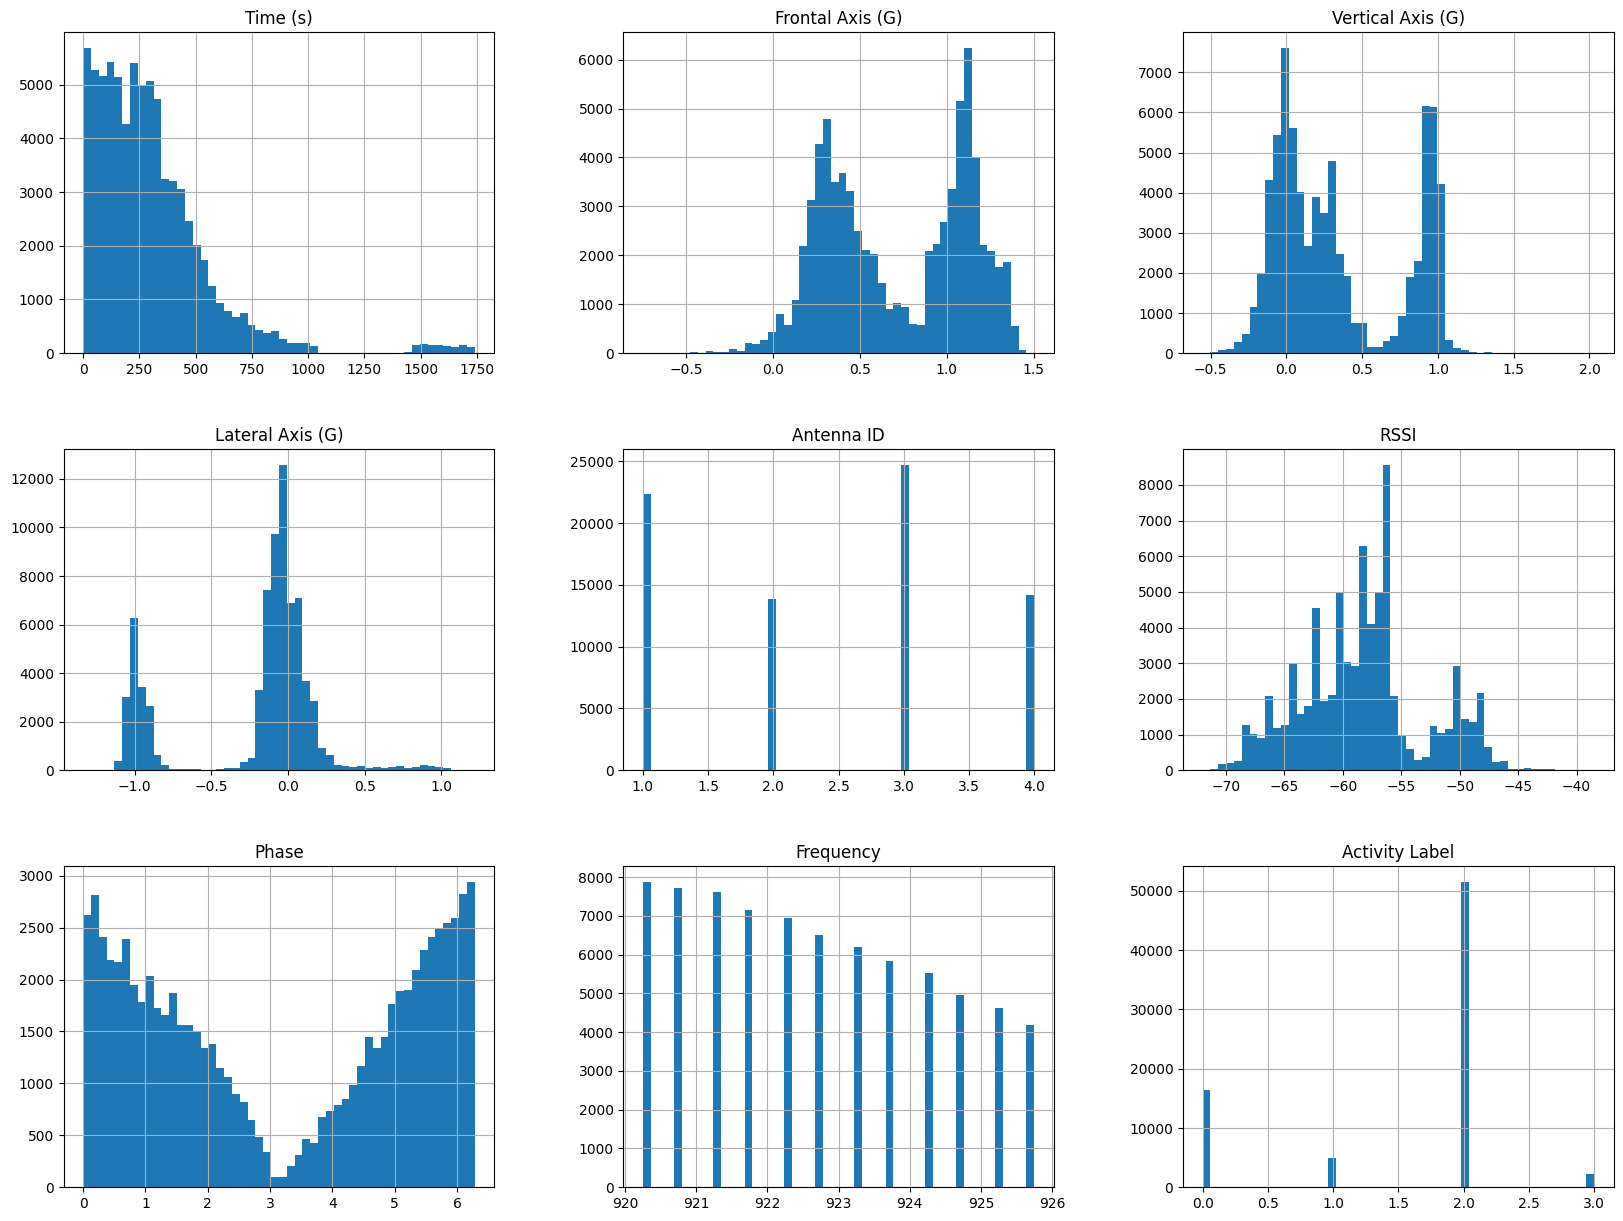

In [3]:
data.hist(bins=50, figsize=(20, 15))
plt.show()

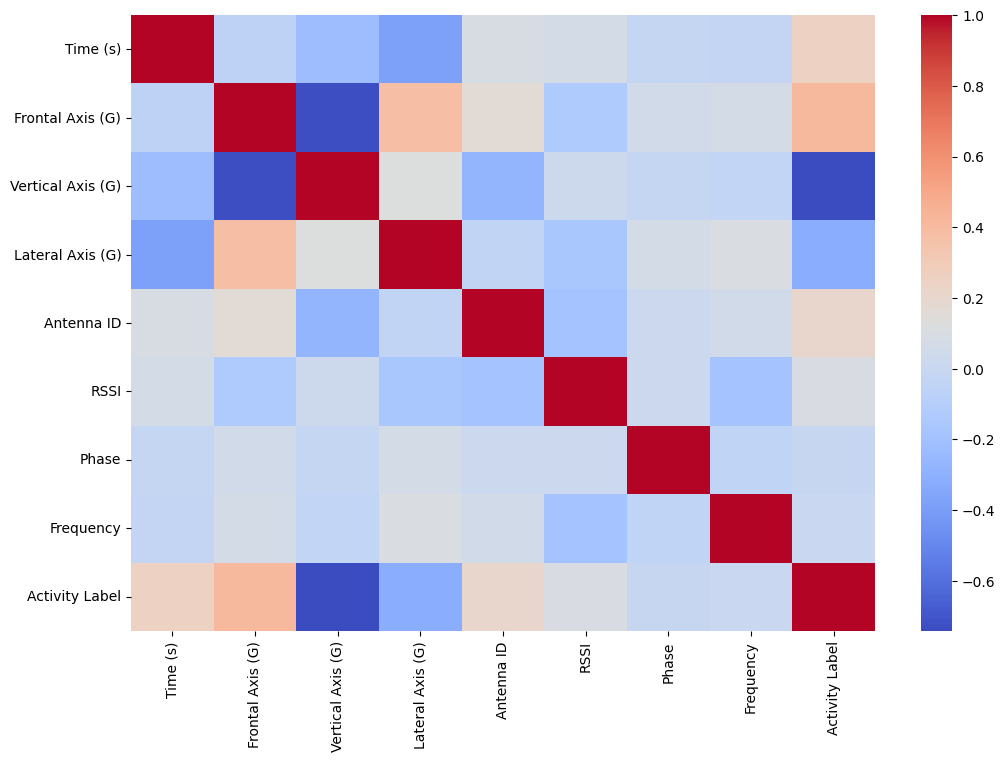

In [4]:
dataq = data.drop("ID", axis=1)
correlation_matrix = dataq.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()

<Figure size 1200x600 with 0 Axes>

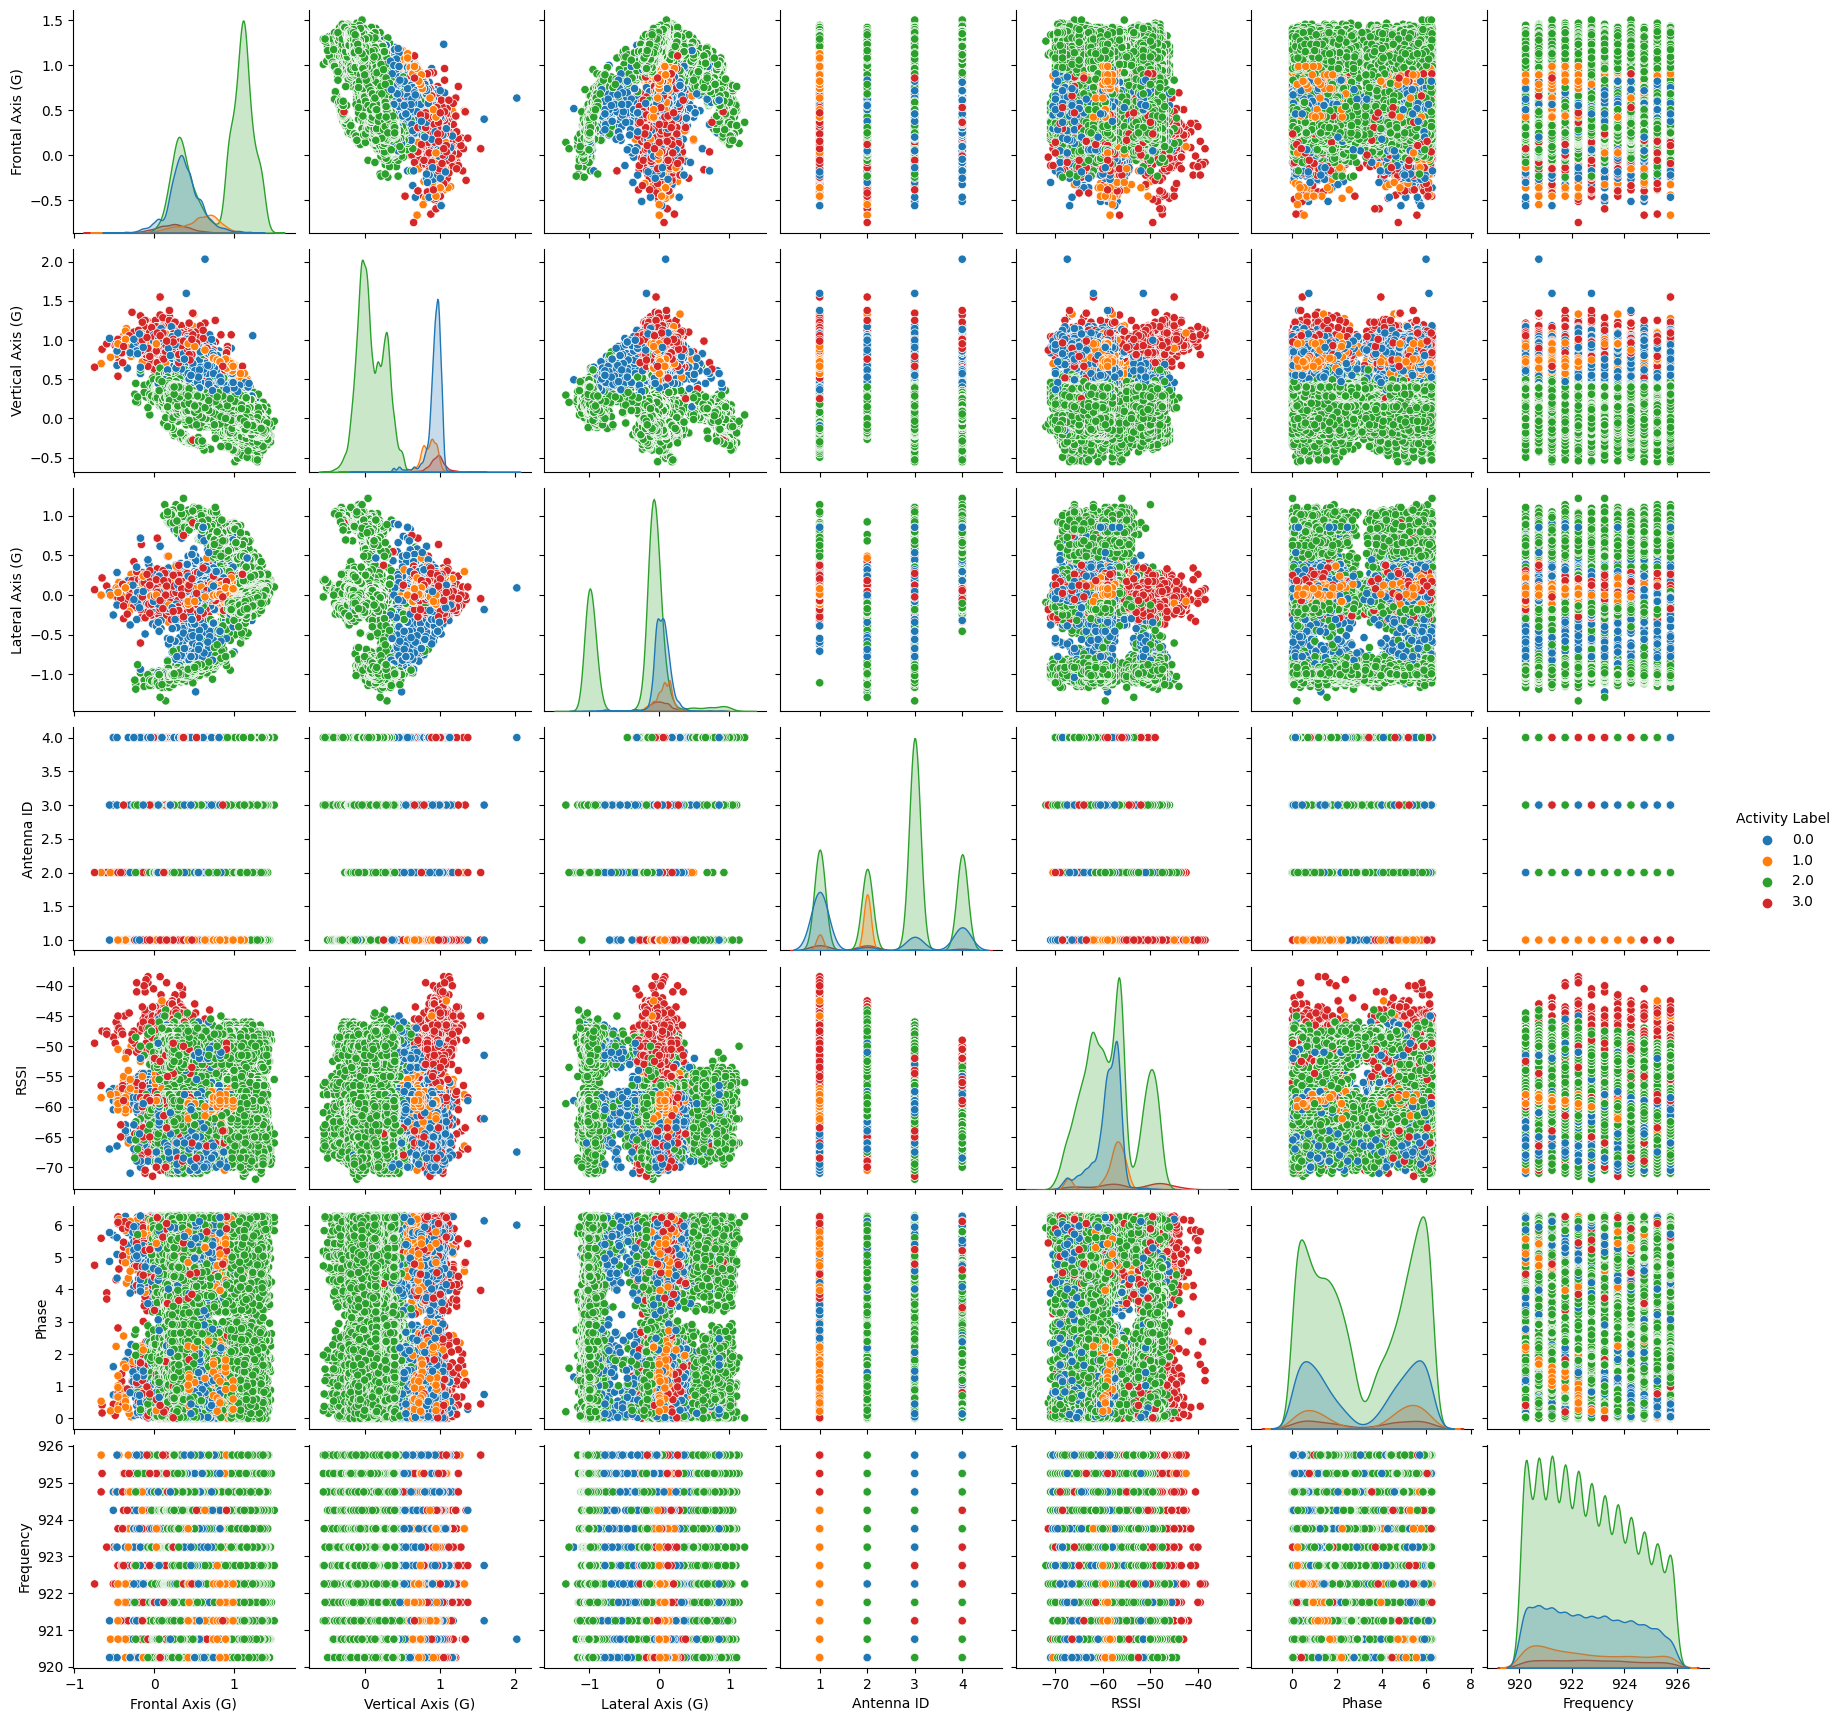

In [5]:
data['Activity Label'] = data['Activity Label'].astype('category')

plt.figure(figsize=(12, 6))
sns.pairplot(data[['Frontal Axis (G)', 'Vertical Axis (G)', 'Lateral Axis (G)','Antenna ID','RSSI','Phase','Frequency', 'Activity Label']], hue='Activity Label')
plt.show()

In [6]:
params = {
    'learning_rate': 0.1,
    'num_leaves': 30
}

lgb_estimator = lgb.LGBMClassifier(objective='multiclass', num_class=4, metric='multi_error', **params)
lgb_estimator.fit(X_train, y_train)

y_pred_lgb = lgb_estimator.predict(X_test)

accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print("Akurasi model LightGBM dengan parameter:", accuracy_lgb)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 60102, number of used features: 8
[LightGBM] [Info] Start training from score -1.524042
[LightGBM] [Info] Start training from score -2.721568
[LightGBM] [Info] Start training from score -0.377289
[LightGBM] [Info] Start training from score -3.484106
Akurasi model LightGBM dengan parameter: 0.98955144416345


In [7]:
rsme = mean_squared_error(y_test, y_pred_lgb, squared=False)
mae = mean_absolute_error(y_test, y_pred_lgb)
precision = precision_score(y_test, y_pred_lgb, average='macro')
recall = recall_score(y_test, y_pred_lgb, average='macro')
f1 = f1_score(y_test, y_pred_lgb, average='macro')

print("RSME:", rsme)
print("MAE:", mae)
print("Presisi:", precision)
print("Recall:", recall)
print("F1-score:", f1)

RSME: 0.2556430860823993
MAE: 0.02475708771462798
Presisi: 0.9651627560809072
Recall: 0.944284250906912
F1-score: 0.9539847566387097


/Users/farrelmanazilin/tomatopotato/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


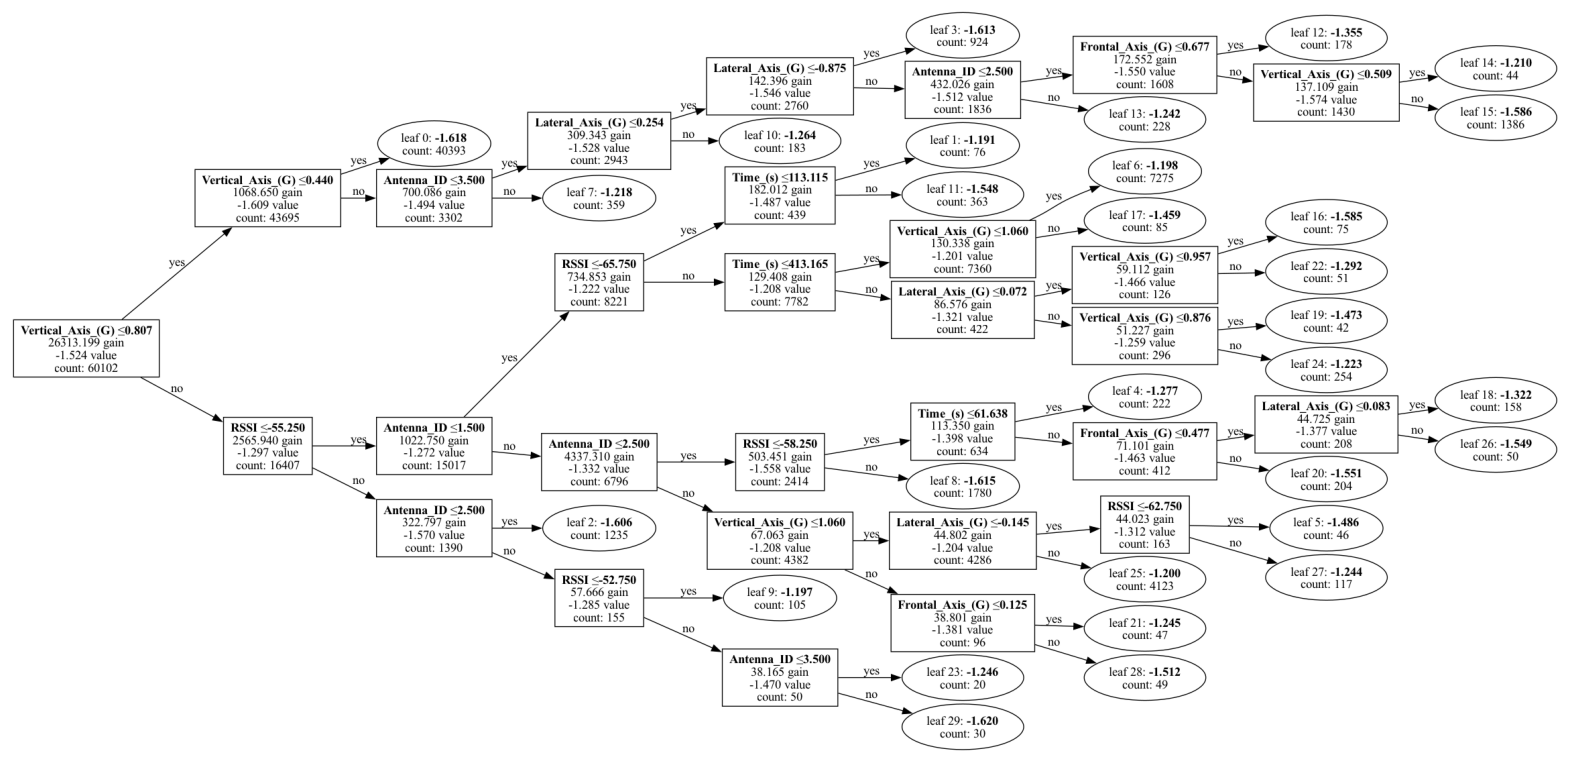

In [8]:
lgb.plot_tree(lgb_estimator, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.show()

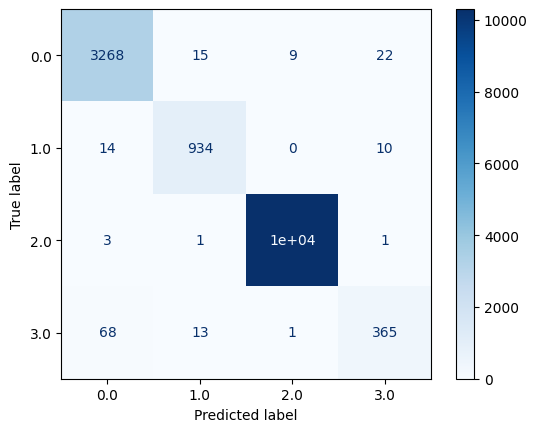

In [9]:
y_pred = lgb_estimator.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgb_estimator.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

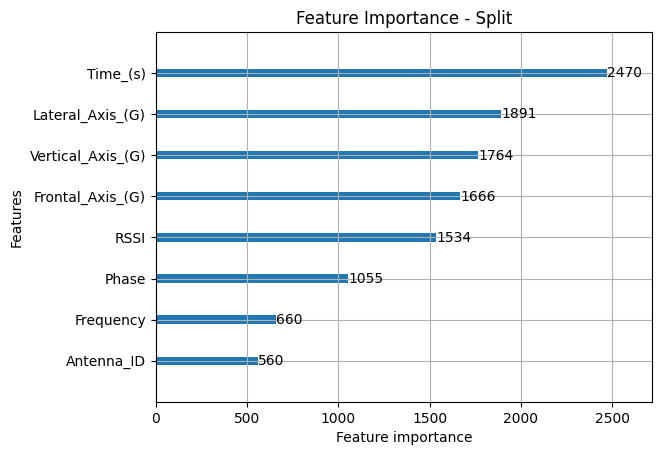

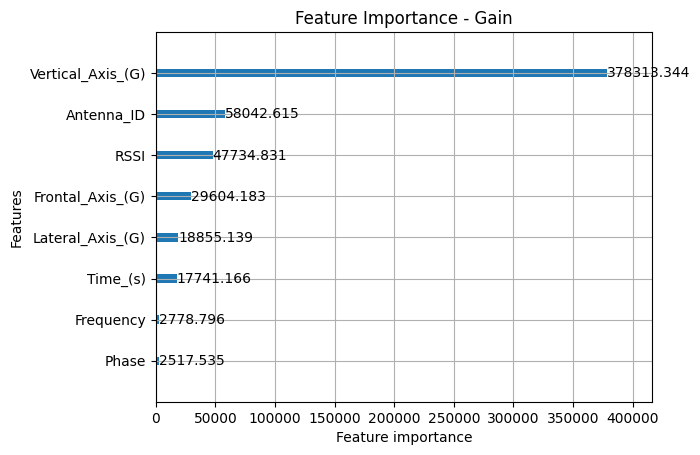

In [10]:
lgb.plot_importance(lgb_estimator, max_num_features=10, importance_type='split')
plt.title("Feature Importance - Split")
plt.show()

lgb.plot_importance(lgb_estimator, max_num_features=10, importance_type='gain')
plt.title("Feature Importance - Gain")
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 4808, number of used features: 8
[LightGBM] [Info] Start training from score -1.556378
[LightGBM] [Info] Start training from score -2.634492
[LightGBM] [Info] Start training from score -0.374542
[LightGBM] [Info] Start training from score -3.515192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

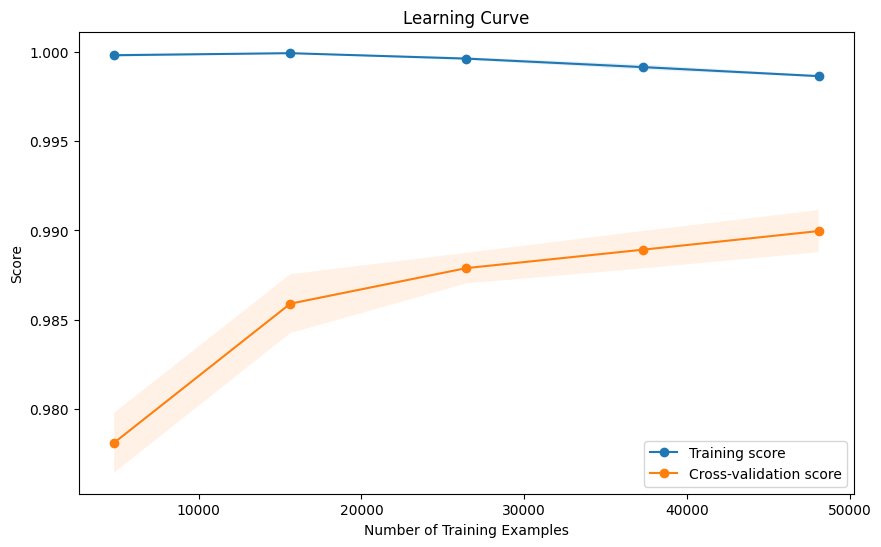

In [11]:
train_sizes, train_scores, val_scores = learning_curve(lgb_estimator, X_train, y_train, cv=5, scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', label='Cross-validation score')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)

plt.xlabel('Number of Training Examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()